### T001_query_chembl

In [5]:
!pip install chembl_webresource_client

import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

In [6]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [7]:
# Create resource objects for API access
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

### Import target

In [8]:
# Get target information from ChEMBL but restrict it to specified values only
uniprot_id = "Q07820"
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Induced myeloid leukemia cell differentiation ...,CHEMBL4361,SINGLE PROTEIN
1,Homo sapiens,Induced myeloid leukemia cell differentiation ...,CHEMBL4361,SINGLE PROTEIN
2,Homo sapiens,Induced myeloid leukemia cell differentiation ...,CHEMBL3430886,PROTEIN-PROTEIN INTERACTION
3,Homo sapiens,Induced myeloid leukemia cell differentiation ...,CHEMBL3430887,PROTEIN-PROTEIN INTERACTION
4,Homo sapiens,Apoptosis regulator BAX/Induced myeloid leukem...,CHEMBL3885515,PROTEIN-PROTEIN INTERACTION
5,Homo sapiens,MCL1-BAK1 complex,CHEMBL3885523,PROTEIN COMPLEX
6,Homo sapiens,MCL1/Protein cereblon,CHEMBL4523712,PROTEIN-PROTEIN INTERACTION


In [9]:
# Select the first entry as our target of interest (target ChEMBL ID: CHEMBL4361)
# CHEMBL4361: It is a single protein and represents the Induced myeloid leukemia cell differentiation protein Mcl-1
target = targets.iloc[0]
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")

The target ChEMBL ID is CHEMBL4361


### Fetch bioactivity data for the target from ChEMBL

In [10]:
# Filter it to only consider：human proteins,bioactivity type IC50,exact measurements (relation '='), and binding data (assay type 'B').
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of bioactivities object: 554, <class 'chembl_webresource_client.query_set.QuerySet'>
Length and type of first element: 13, <class 'dict'>


{'activity_id': 1773940,
 'assay_chembl_id': 'CHEMBL909447',
 'assay_description': 'Displacement of FAM-Bid from human Mcl1 by FP assay',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL410802',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '52.0',
 'target_chembl_id': 'CHEMBL4361',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '0.052'}

In [11]:
# only download IC 50 value as bioactivity data from website
bioactivities_df = pd.read_csv(DATA/ "MCL_download.csv",sep=";")
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (1825, 45)


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL3126318,NaN,0,256.30,0,3.71,36,CCCc1ccc(-c2ccc(O)c(C(=O)O)c2)cc1,IC50,'=',...,Induced myeloid leukemia cell differentiation ...,Homo sapiens,SINGLE PROTEIN,CHEMBL3124895,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,None,NaN
1,CHEMBL3126322,NaN,0,300.35,0,4.07,40,CC(C)(C)OCc1ccccc1-c1ccc(O)c(C(=O)O)c1,IC50,'>',...,Induced myeloid leukemia cell differentiation ...,Homo sapiens,SINGLE PROTEIN,CHEMBL3124895,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,None,NaN
2,CHEMBL3126311,NaN,0,527.60,2,5.59,24,Cc1ccc(-c2ccc(C(=O)O)c(NS(=O)(=O)c3ccc(OCCn4cc...,IC50,'=',...,Induced myeloid leukemia cell differentiation ...,Homo sapiens,SINGLE PROTEIN,CHEMBL3124895,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,None,NaN
3,CHEMBL3126333,NaN,0,303.34,0,2.83,1,C=Cc1ccc(C(=O)O)c(NS(=O)(=O)c2ccccc2)c1,IC50,'=',...,Induced myeloid leukemia cell differentiation ...,Homo sapiens,SINGLE PROTEIN,CHEMBL3124895,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,None,NaN
4,CHEMBL3963557,NaN,0,421.46,1,5.82,BDBM231571,COc1cccc(-c2ccc3nc(-c4ccco4)cc(C(=O)Nc4cccnc4)...,IC50,'=',...,Induced myeloid leukemia cell differentiation ...,Homo sapiens,SINGLE PROTEIN,CHEMBL3886732,37,BindingDB Database,NaN,2016.0,None,NaN


In [12]:
bioactivities_df.dtypes

Molecule ChEMBL ID             object
Molecule Name                  object
Molecule Max Phase              int64
Molecular Weight              float64
#RO5 Violations                object
AlogP                          object
Compound Key                   object
Smiles                         object
Standard Type                  object
Standard Relation              object
Standard Value                float64
Standard Units                 object
pChEMBL Value                 float64
Data Validity Comment          object
Comment                        object
Uo Units                       object
Ligand Efficiency BEI         float64
Ligand Efficiency LE           object
Ligand Efficiency LLE          object
Ligand Efficiency SEI          object
Potential Duplicate             int64
Assay ChEMBL ID                object
Assay Description              object
Assay Type                     object
BAO Format ID                  object
BAO Label                      object
Assay Organi

In [13]:
# Keep only entries with "standard_unit == nM“ and binding data (assay type 'B'）
print(f"Units in downloaded data: {bioactivities_df['Standard Units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['Standard Units'] != 'nM'].shape[0]}"
)

print(f"Binding data in downloaded data: {bioactivities_df['Assay Type'].unique()}")
print(
    f"Number of non-binding entries:\
    {bioactivities_df[bioactivities_df['Assay Type'] != 'B'].shape[0]}"
)
print(f"DataFrame shape: {bioactivities_df.shape}")

Units in downloaded data: ['nM' nan 'ug.mL-1' 'µM']
Number of non-nM entries:    23
Binding data in downloaded data: ['B' 'F']
Number of non-binding entries:    1106
DataFrame shape: (1825, 45)


In [14]:
bioactivities_df = bioactivities_df[bioactivities_df["Standard Units"] == "nM"]
bioactivities_df = bioactivities_df[bioactivities_df["Assay Type"] == "B"]
bioactivities_df = bioactivities_df[bioactivities_df["Standard Relation"] == "'='"]
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (553, 45)


In [15]:
#Reset "DataFrame" index
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL3126318,NaN,0,256.30,0,3.71,36,CCCc1ccc(-c2ccc(O)c(C(=O)O)c2)cc1,IC50,'=',...,Induced myeloid leukemia cell differentiation ...,Homo sapiens,SINGLE PROTEIN,CHEMBL3124895,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,None,NaN
1,CHEMBL3126311,NaN,0,527.60,2,5.59,24,Cc1ccc(-c2ccc(C(=O)O)c(NS(=O)(=O)c3ccc(OCCn4cc...,IC50,'=',...,Induced myeloid leukemia cell differentiation ...,Homo sapiens,SINGLE PROTEIN,CHEMBL3124895,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,None,NaN
2,CHEMBL3126333,NaN,0,303.34,0,2.83,1,C=Cc1ccc(C(=O)O)c(NS(=O)(=O)c2ccccc2)c1,IC50,'=',...,Induced myeloid leukemia cell differentiation ...,Homo sapiens,SINGLE PROTEIN,CHEMBL3124895,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,None,NaN
3,CHEMBL3963557,NaN,0,421.46,1,5.82,BDBM231571,COc1cccc(-c2ccc3nc(-c4ccco4)cc(C(=O)Nc4cccnc4)...,IC50,'=',...,Induced myeloid leukemia cell differentiation ...,Homo sapiens,SINGLE PROTEIN,CHEMBL3886732,37,BindingDB Database,NaN,2016.0,None,NaN
4,CHEMBL3951188,NaN,0,504.60,2,7.63,BDBM231610,O=C(Nc1nc2ccccc2s1)c1cc(-c2ccco2)nc2ccc(-c3ccc...,IC50,'=',...,Induced myeloid leukemia cell differentiation ...,Homo sapiens,SINGLE PROTEIN,CHEMBL3886732,37,BindingDB Database,NaN,2016.0,None,NaN


In [16]:
bioactivities_df.rename(
    columns={"Molecule ChEMBL ID":"molecule_chembl_id","Standard Value": "IC50", "Standard Units": "units"}, inplace=True
)
bioactivities_df.dtypes

molecule_chembl_id             object
Molecule Name                  object
Molecule Max Phase              int64
Molecular Weight              float64
#RO5 Violations                object
AlogP                          object
Compound Key                   object
Smiles                         object
Standard Type                  object
Standard Relation              object
IC50                          float64
units                          object
pChEMBL Value                 float64
Data Validity Comment          object
Comment                        object
Uo Units                       object
Ligand Efficiency BEI         float64
Ligand Efficiency LE           object
Ligand Efficiency LLE          object
Ligand Efficiency SEI          object
Potential Duplicate             int64
Assay ChEMBL ID                object
Assay Description              object
Assay Type                     object
BAO Format ID                  object
BAO Label                      object
Assay Organi

In [17]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (553, 45)


In [18]:
#Fetch compound data from ChEMBL
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")
compounds = list(tqdm(compounds_provider))

  0%|          | 0/518 [00:00<?, ?it/s]

In [19]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")
compounds_df.head()

DataFrame shape: (518, 2)


,molecule_chembl_id,molecule_structures
0,CHEMBL6466,"{'canonical_smiles': 'O=c1ccc2ccccc2o1', 'molf..."
1,CHEMBL276618,{'canonical_smiles': 'Cc1cc(=O)oc2c(O)c(O)ccc1...
2,CHEMBL12208,"{'canonical_smiles': 'Cc1cc(=O)oc2cc(O)ccc12',..."
3,CHEMBL51483,{'canonical_smiles': 'Cc1cc2c(C(C)C)c(O)c(O)c(...
4,CHEMBL51628,"{'canonical_smiles': 'O=c1ccc2ccc(O)cc2o1', 'm..."


In [20]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (518, 2)


### Preprocess and filter compound data

In [21]:
#1. Remove entries with missing entries 
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")
#2. Delete duplicate molecules
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")
#3. Get molecules with canonical SMILES
compounds_df.iloc[0].molecule_structures.keys()

canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (518, 2)
DataFrame shape: (518, 2)
DataFrame shape: (518, 2)


In [22]:
# Output (bioactivity-compound) data
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 553


Index(['molecule_chembl_id', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'IC50', 'units',
       'pChEMBL Value', 'Data Validity Comment', 'Comment', 'Uo Units',
       'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties'],
      dtype='object')

In [23]:
# Output compounds data
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 518


Index(['molecule_chembl_id', 'smiles'], dtype='object')

In [24]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on='molecule_chembl_id',
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 553 entries.


In [25]:
output_df.dtypes

molecule_chembl_id     object
IC50                  float64
units                  object
smiles                 object
dtype: object

In [26]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL3126318,3300.0,nM,CCCc1ccc(-c2ccc(O)c(C(=O)O)c2)cc1
1,CHEMBL3126311,30.0,nM,Cc1ccc(-c2ccc(C(=O)O)c(NS(=O)(=O)c3ccc(OCCn4cc...
2,CHEMBL3126333,5000.0,nM,C=Cc1ccc(C(=O)O)c(NS(=O)(=O)c2ccccc2)c1
3,CHEMBL3126333,5000.0,nM,C=Cc1ccc(C(=O)O)c(NS(=O)(=O)c2ccccc2)c1
4,CHEMBL3963557,1500.0,nM,COc1cccc(-c2ccc3nc(-c4ccco4)cc(C(=O)Nc4cccnc4)...
5,CHEMBL3951188,4800.0,nM,O=C(Nc1nc2ccccc2s1)c1cc(-c2ccco2)nc2ccc(-c3ccc...
6,CHEMBL3975916,5000.0,nM,O=C(Nc1cccnc1)c1cc(-c2ccco2)nc2ccc(-c3ccc(F)cc...
7,CHEMBL3909705,6300.0,nM,O=C(Nc1cccnc1)c1cc(-c2ccco2)nc2ccc(-c3cccc(Oc4...
8,CHEMBL3924786,2400.0,nM,O=C(Nc1cccnc1)c1cc(-c2ccco2)nc2ccc(-c3ccc4cc[n...
9,CHEMBL3984546,8600.0,nM,CN1CCN(C(=O)c2cc(-c3ccco3)nc3ccc(-c4ccc5scnc5c...


In [27]:
#Add pIC50 values
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL3126318,3300.0,nM,CCCc1ccc(-c2ccc(O)c(C(=O)O)c2)cc1,5.481486
1,CHEMBL3126311,30.0,nM,Cc1ccc(-c2ccc(C(=O)O)c(NS(=O)(=O)c3ccc(OCCn4cc...,7.522879
2,CHEMBL3126333,5000.0,nM,C=Cc1ccc(C(=O)O)c(NS(=O)(=O)c2ccccc2)c1,5.301030
3,CHEMBL3126333,5000.0,nM,C=Cc1ccc(C(=O)O)c(NS(=O)(=O)c2ccccc2)c1,5.301030
4,CHEMBL3963557,1500.0,nM,COc1cccc(-c2ccc3nc(-c4ccco4)cc(C(=O)Nc4cccnc4)...,5.823909


array([[<AxesSubplot:title={'center':'pIC50'}>]], dtype=object)

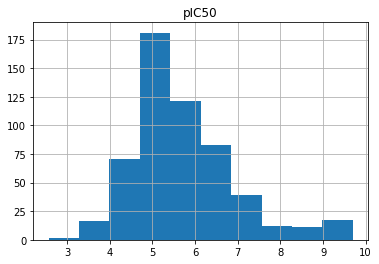

In [28]:
#Draw compound data
#1.plot the pIC50 value distribution
output_df.hist(column="pIC50")

In [29]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

,molecule_chembl_id,IC50,units,pIC50,ROMol
0,CHEMBL4535151,0.2,nM,9.69897,
1,CHEMBL4580244,0.2,nM,9.69897,
2,CHEMBL4553660,0.2,nM,9.69897,

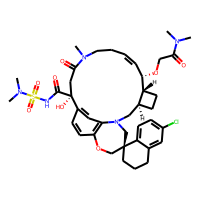
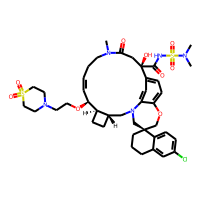
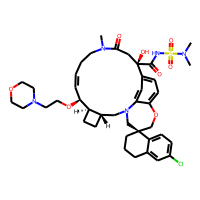

In [30]:
#how the three most active molecules, i.e. molecules with the highest pIC50 values.
output_df.drop("smiles", axis=1).head(3)

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,CHEMBL4535151,0.2,nM,CN(C)C(=O)CO[C@H]1/C=C/CCN(C)C(=O)C[C@](O)(C(=...,9.698970,
1,CHEMBL4580244,0.2,nM,CN1CC/C=C/[C@H](OCCN2CCS(=O)(=O)CC2)[C@@H]2CC[...,9.698970,
2,CHEMBL4553660,0.2,nM,CN1CC/C=C/[C@H](OCCN2CCOCC2)[C@@H]2CC[C@H]2CN2...,9.698970,
3,CHEMBL4464768,0.3,nM,CN1CC/C=C/[C@H](OCCNCC(F)(F)CO)[C@@H]2CC[C@H]2...,9.522879,
4,CHEMBL4446369,0.3,nM,CN1CC/C=C/[C@H](OCCN2CC(F)(F)C2)[C@@H]2CC[C@H]...,9.522879,

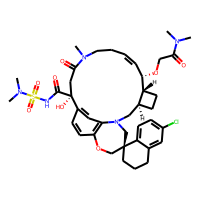
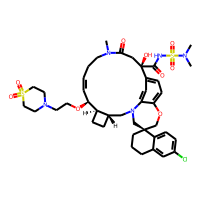
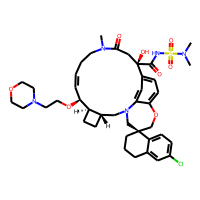
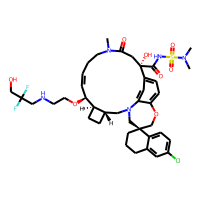
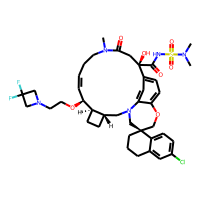

In [31]:
#Write output data to file
output_df.to_csv(DATA / "MCL_compounds.csv")
output_df.head()

In [32]:
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (553, 6)
